# Text Generation using Transformer for Sherlock Holmes (Step-by-step, comparable to GRU)


In [1]:
import os
from collections import Counter
import re
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import tensorflow as tf
import matplotlib.pyplot as plt
import platform
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

# Weights & Biases (toggle)
USE_WANDB = True  # set False to disable
if USE_WANDB:
    import wandb
    from wandb.integration.keras import WandbMetricsLogger
    # If you want online logging, ensure WANDB_API_KEY is set in your environment
    # For offline logging: export WANDB_MODE=offline
    wandb.login()
    wandb.init(project='nlp-arch-compare', group='transformer')


Python version: 3.13.0
Tensorflow version: 2.20.0
Keras version: 3.11.3


wandb: Currently logged in as: sofiesch (sofiesch-kth-royal-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: setting up run 51lxgv3z


wandb: Tracking run with wandb version 0.22.1


wandb: Run data is saved locally in /Users/sofieschnitzer/Desktop/KTH_HT25_filer/II2202/NLP-architecture-comparison/wandb/run-20251006_212650-51lxgv3z
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run fresh-fog-7


wandb: ⭐️ View project at https://wandb.ai/sofiesch-kth-royal-institute-of-technology/nlp-arch-compare


wandb: 🚀 View run at https://wandb.ai/sofiesch-kth-royal-institute-of-technology/nlp-arch-compare/runs/51lxgv3z


In [2]:
# Dataset path (same as GRU)
cache_dir = './tmp-transformer'
dataset_file_name = 'sherlockholmes.txt'
dataset_file_path = dataset_file_name
print('Using dataset file:', dataset_file_path)

# Load data
text = open(dataset_file_path, mode='r').read()
print(text[:250])


Using dataset file: sherlockholmes.txt
The Adventures of Sherlock Holmes

by Arthur Conan Doyle

I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her


In [3]:
# Tokenizer and data pipeline (mirrors GRU)
from tokenizers import ByteLevelBPETokenizer
from transformers import GPT2Tokenizer

save_dir = "./tokenizer"
# Train tokenizer if folder is empty
if (not os.path.exists(save_dir)) or (len(os.listdir(save_dir)) == 0):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files=[dataset_file_path], vocab_size=30_000, min_frequency=2)
    os.makedirs(save_dir, exist_ok=True)
    tokenizer.save_model(save_dir)

custom_tokenizer = GPT2Tokenizer.from_pretrained(save_dir)

# Tokenize full text
input_ids = custom_tokenizer.encode(text)
print(f"Total tokens in text: {len(input_ids)}")

# Build tf.data pipeline
import tensorflow as tf

tokens_dataset = tf.data.Dataset.from_tensor_slices(input_ids)
sequence_length = 100
examples_per_epoch = len(input_ids) // (sequence_length + 1)
print(f'Examples per epoch: {examples_per_epoch}')

sequences = tokens_dataset.batch(sequence_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print('Batched dataset size:', len(list(dataset.as_numpy_iterator())))


Total tokens in text: 144597
Examples per epoch: 1431


Batched dataset size: 22


2025-10-06 21:26:53.302788: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Show some examples of input-target pairs (like GRU)
# Use the unbatched (sequence_length) view to avoid confusion with batch dimension
preview_ds = sequences.map(split_input_target)
for input_example, target_example in preview_ds.take(1):
    for i in range(5):
        input_token = int(input_example[i].numpy())
        target_token = int(target_example[i].numpy())
        print(f'Step {i:2d}')
        print(f'  input token: {input_token} ({custom_tokenizer.decode([input_token])})')
        print(f'  expected output token: {target_token} ({custom_tokenizer.decode([target_token])})')


Step  0
  input token: 364 (The)
  expected output token: 407 ( A)
Step  1
  input token: 407 ( A)
  expected output token: 67 (d)
Step  2
  input token: 67 (d)
  expected output token: 2428 (venture)
Step  3
  input token: 2428 (venture)
  expected output token: 82 (s)
Step  4
  input token: 82 (s)
  expected output token: 283 ( of)


2025-10-06 21:26:53.320061: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Transformer model (dynamic positional encoding)
import tensorflow as tf

EMBED_DIM = 256
MODEL_DIM = 256
NUM_HEADS = 8
FF_DIM = 1024
NUM_LAYERS = 4
DROPOUT = 0.1


def positional_encoding_dynamic(seq_len: tf.Tensor, depth: int) -> tf.Tensor:
    pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
    idx = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    angle_rates = 1.0 / tf.pow(10000.0, (2 * (idx // 2)) / tf.cast(depth, tf.float32))
    angles = pos * angle_rates
    sines = tf.math.sin(angles[:, 0::2])
    cosines = tf.math.cos(angles[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return pos_encoding[tf.newaxis, ...]


def transformer_block(x: tf.Tensor, model_dim: int, ff_dim: int, num_heads: int, dropout: float) -> tf.Tensor:
    attn_out = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=model_dim, dropout=dropout)(x, x)
    attn_out = tf.keras.layers.Dropout(dropout)(attn_out)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_out)

    ff = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(model_dim),
    ])
    ff_out = ff(x)
    ff_out = tf.keras.layers.Dropout(dropout)(ff_out)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_out)
    return x


def build_model(vocab_size, embed_dim, model_dim, num_heads, ff_dim, num_layers, dropout):
    inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int32)
    emb = tf.keras.layers.Embedding(vocab_size, embed_dim)(inputs)
    proj = tf.keras.layers.Dense(model_dim)(emb)

    def add_positional(x):
        seq_len = tf.shape(x)[1]
        pe = positional_encoding_dynamic(seq_len, model_dim)
        return x + pe

    x = tf.keras.layers.Lambda(add_positional)(proj)

    for _ in range(num_layers):
        x = transformer_block(x, model_dim, ff_dim, num_heads, dropout)

    logits = tf.keras.layers.Dense(vocab_size)(x)
    model = tf.keras.Model(inputs, logits, name="token_transformer")
    return model

vocab_size = custom_tokenizer.vocab_size + 1
model = build_model(vocab_size, EMBED_DIM, MODEL_DIM, NUM_HEADS, FF_DIM, NUM_LAYERS, DROPOUT)
model.summary()


Model: "token_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,366,976 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 256) │     65,792 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 256) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  2,103,552 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 256) │          0 │ lambda[0][0],     │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 256) │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 256) │    525,568 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 256) │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 256) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None, 256) │    525,568 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, None, 256) │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 256) │          0 │ layer_normalizat

 Total params: 15,329,566 (58.48 MB)

 Trainable params: 15,329,566 (58.48 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile + callbacks (checkpoints, ResourceMonitorCB, and optional W&B)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=loss)

# Checkpoints
checkpoint_dir = cache_dir + '/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.weights.h5')
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_best_only=True,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    verbose=1
)

# Early stopping only (match GRU); W&B handles system metrics
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Build callbacks list with optional W&B logger
callbacks = [checkpoint_cb, early_stopping]
if 'USE_WANDB' in globals() and USE_WANDB:
    callbacks.append(WandbMetricsLogger())


Epoch 1/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:31 7s/step - loss: 9.1820


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - loss: 9.0749


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - loss: 8.9878


 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - loss: 8.9112


 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - loss: 8.8407


 6/22 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 8.7747 


 7/22 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 8.7118


 8/22 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 8.6515


 9/22 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - loss: 8.5930


10/22 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - loss: 8.5365


11/22 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - loss: 8.4821


12/22 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - loss: 8.4295


13/22 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - loss: 8.3787


14/22 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - loss: 8.3297


15/22 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - loss: 8.2824


16/22 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - loss: 8.2366


17/22 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - loss: 8.1926


18/22 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 8.1505


19/22 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 8.1100


20/22 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - loss: 8.0710 


21/22 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - loss: 8.0336


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 7.9979


Epoch 1: loss improved from None to 7.24724, saving model to ./tmp-transformer/checkpoints/model_epoch_01.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 7.2472


Epoch 2/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - loss: 6.3800


 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:26 7s/step - loss: 6.3819


 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - loss: 6.3834


 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:59 10s/step - loss: 6.3840


 5/22 ━━━━━━━━━━━━━━━━━━━━ 3:11 11s/step - loss: 6.3857


 6/22 ━━━━━━━━━━━━━━━━━━━━ 3:29 13s/step - loss: 6.3884


 7/22 ━━━━━━━━━━━━━━━━━━━━ 3:08 13s/step - loss: 6.3898


 8/22 ━━━━━━━━━━━━━━━━━━━━ 2:50 12s/step - loss: 6.3908


 9/22 ━━━━━━━━━━━━━━━━━━━━ 2:41 12s/step - loss: 6.3912


10/22 ━━━━━━━━━━━━━━━━━━━━ 2:34 13s/step - loss: 6.3909


11/22 ━━━━━━━━━━━━━━━━━━━━ 2:18 13s/step - loss: 6.3909


12/22 ━━━━━━━━━━━━━━━━━━━━ 2:03 12s/step - loss: 6.3907


13/22 ━━━━━━━━━━━━━━━━━━━━ 1:58 13s/step - loss: 6.3907


14/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 13s/step - loss: 6.3907


15/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 14s/step - loss: 6.3909


16/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 13s/step - loss: 6.3909


17/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 13s/step - loss: 6.3907


18/22 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - loss: 6.3906 


19/22 ━━━━━━━━━━━━━━━━━━━━ 37s 13s/step - loss: 6.3907


20/22 ━━━━━━━━━━━━━━━━━━━━ 24s 12s/step - loss: 6.3908


21/22 ━━━━━━━━━━━━━━━━━━━━ 11s 12s/step - loss: 6.3909


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 6.3909 


Epoch 2: loss improved from 7.24724 to 6.39108, saving model to ./tmp-transformer/checkpoints/model_epoch_02.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 243s 11s/step - loss: 6.3911


Epoch 3/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 6.3465


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 6.3554


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - loss: 6.3557


 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - loss: 6.3543


 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - loss: 6.3528


 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - loss: 6.3523


 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - loss: 6.3533


 8/22 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 6.3540 


 9/22 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 6.3546


10/22 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 6.3557


11/22 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - loss: 6.3573


12/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 6.3590


13/22 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 6.3605


14/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 6.3619


15/22 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 6.3633


16/22 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 6.3647


17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - loss: 6.3659


18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 6.3669


19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 6.3676


20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 6.3680


21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 6.3684 


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.3688


Epoch 3: loss improved from 6.39108 to 6.37564, saving model to ./tmp-transformer/checkpoints/model_epoch_03.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - loss: 6.3756


Epoch 4/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:05 6s/step - loss: 6.3412


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - loss: 6.3417


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - loss: 6.3413


 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 6.3420


 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - loss: 6.3409


 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - loss: 6.3391


 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - loss: 6.3397


 8/22 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 6.3413 


 9/22 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 6.3431


10/22 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 6.3452


11/22 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - loss: 6.3466


12/22 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - loss: 6.3475


13/22 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - loss: 6.3481


14/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 6.3488


15/22 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - loss: 6.3494


16/22 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - loss: 6.3500


17/22 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - loss: 6.3507


18/22 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 6.3515


19/22 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 6.3523


20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 6.3530 


21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 6.3537


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.3546


Epoch 4: loss improved from 6.37564 to 6.37270, saving model to ./tmp-transformer/checkpoints/model_epoch_04.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - loss: 6.3727


Epoch 5/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 5s/step - loss: 6.3814


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 4s/step - loss: 6.3746


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - loss: 6.3740


 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - loss: 6.3780


 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - loss: 6.3783


 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - loss: 6.3793


 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - loss: 6.3786


 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - loss: 6.3776


 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 5s/step - loss: 6.3767


10/22 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - loss: 6.3758 


11/22 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 6.3748


12/22 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - loss: 6.3740


13/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 6.3735


14/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 6.3734


15/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 6.3733


16/22 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 6.3731


17/22 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - loss: 6.3730


18/22 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 6.3730


19/22 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - loss: 6.3730


20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 6.3729 


21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 6.3728


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.3726


Epoch 5: loss improved from 6.37270 to 6.37037, saving model to ./tmp-transformer/checkpoints/model_epoch_05.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - loss: 6.3704


Epoch 6/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 5s/step - loss: 6.3412


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 6s/step - loss: 6.3448


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 6.3547


 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 6.3604


 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - loss: 6.3624


 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - loss: 6.3631


 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - loss: 6.3636


 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - loss: 6.3628


 9/22 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 6.3621 


10/22 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - loss: 6.3619


11/22 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - loss: 6.3620


12/22 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 6.3622


13/22 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - loss: 6.3626


14/22 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 6.3625


15/22 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - loss: 6.3627


16/22 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - loss: 6.3626


17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - loss: 6.3627


18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 6.3628


19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 6.3630


20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 6.3633


21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 6.3637 


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 6.3639


Epoch 6: loss improved from 6.37037 to 6.36782, saving model to ./tmp-transformer/checkpoints/model_epoch_06.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - loss: 6.3678


Epoch 7/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 5s/step - loss: 6.3884


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 6.3769


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 6.3772


 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 6.3734


 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 6.3717


 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - loss: 6.3717


 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - loss: 6.3704


 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 6.3689


 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - loss: 6.3678


10/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 5s/step - loss: 6.3672


11/22 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - loss: 6.3665 


12/22 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - loss: 6.3661


13/22 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 6.3657


14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 6.3656


15/22 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - loss: 6.3655


16/22 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 6.3653


17/22 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 6.3652


18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 6.3649


19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 6.3647


20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 6.3647


21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 6.3647 


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.3648


Epoch 7: loss improved from 6.36782 to 6.36733, saving model to ./tmp-transformer/checkpoints/model_epoch_07.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - loss: 6.3673


Epoch 8/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 5s/step - loss: 6.3354


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 5s/step - loss: 6.3559


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 6s/step - loss: 6.3670


 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 6.3674


 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 6.3685


 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 6.3670


 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 6s/step - loss: 6.3662


 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 7s/step - loss: 6.3653


 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 7s/step - loss: 6.3646


10/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 7s/step - loss: 6.3642


11/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 8s/step - loss: 6.3642


12/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 8s/step - loss: 6.3641


13/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 8s/step - loss: 6.3638


14/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 9s/step - loss: 6.3633


15/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 9s/step - loss: 6.3630


16/22 ━━━━━━━━━━━━━━━━━━━━ 57s 10s/step - loss: 6.3627


17/22 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - loss: 6.3626


18/22 ━━━━━━━━━━━━━━━━━━━━ 42s 11s/step - loss: 6.3626


19/22 ━━━━━━━━━━━━━━━━━━━━ 32s 11s/step - loss: 6.3628


20/22 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step - loss: 6.3629


21/22 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 6.3630


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 6.3632 


Epoch 8: loss improved from 6.36733 to 6.36710, saving model to ./tmp-transformer/checkpoints/model_epoch_08.weights.h5



22/22 ━━━━━━━━━━━━━━━━━━━━ 256s 12s/step - loss: 6.3671


Epoch 9/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 4:54 14s/step - loss: 6.2858


 2/22 ━━━━━━━━━━━━━━━━━━━━ 4:12 13s/step - loss: 6.3180


 3/22 ━━━━━━━━━━━━━━━━━━━━ 4:27 14s/step - loss: 6.3203


 4/22 ━━━━━━━━━━━━━━━━━━━━ 3:56 13s/step - loss: 6.3206


 5/22 ━━━━━━━━━━━━━━━━━━━━ 3:43 13s/step - loss: 6.3242


 6/22 ━━━━━━━━━━━━━━━━━━━━ 3:43 14s/step - loss: 6.3284


 7/22 ━━━━━━━━━━━━━━━━━━━━ 3:23 14s/step - loss: 6.3320


 8/22 ━━━━━━━━━━━━━━━━━━━━ 3:05 13s/step - loss: 6.3340


 9/22 ━━━━━━━━━━━━━━━━━━━━ 2:47 13s/step - loss: 6.3351


10/22 ━━━━━━━━━━━━━━━━━━━━ 2:31 13s/step - loss: 6.3362


11/22 ━━━━━━━━━━━━━━━━━━━━ 2:17 12s/step - loss: 6.3381


12/22 ━━━━━━━━━━━━━━━━━━━━ 2:03 12s/step - loss: 6.3399


13/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 12s/step - loss: 6.3417


14/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 12s/step - loss: 6.3433


15/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 12s/step - loss: 6.3448


16/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 12s/step - loss: 6.3462


17/22 ━━━━━━━━━━━━━━━━━━━━ 59s 12s/step - loss: 6.3475 


18/22 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - loss: 6.3486


19/22 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - loss: 6.3496


20/22 ━━━━━━━━━━━━━━━━━━━━ 23s 12s/step - loss: 6.3505


21/22 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 6.3515


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 6.3522 


Epoch 9: loss did not improve from 6.36710



22/22 ━━━━━━━━━━━━━━━━━━━━ 253s 11s/step - loss: 6.3688


Epoch 10/10



 1/22 ━━━━━━━━━━━━━━━━━━━━ 4:08 12s/step - loss: 6.2565


 2/22 ━━━━━━━━━━━━━━━━━━━━ 3:53 12s/step - loss: 6.2796


 3/22 ━━━━━━━━━━━━━━━━━━━━ 3:24 11s/step - loss: 6.2926


 4/22 ━━━━━━━━━━━━━━━━━━━━ 3:16 11s/step - loss: 6.3028


 5/22 ━━━━━━━━━━━━━━━━━━━━ 3:01 11s/step - loss: 6.3097


 6/22 ━━━━━━━━━━━━━━━━━━━━ 2:47 10s/step - loss: 6.3151


 7/22 ━━━━━━━━━━━━━━━━━━━━ 2:24 10s/step - loss: 6.3201


 8/22 ━━━━━━━━━━━━━━━━━━━━ 2:07 9s/step - loss: 6.3234 


 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 9s/step - loss: 6.3261


10/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 8s/step - loss: 6.3284


11/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 8s/step - loss: 6.3306


12/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 8s/step - loss: 6.3320


13/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 8s/step - loss: 6.3330


14/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 8s/step - loss: 6.3340


15/22 ━━━━━━━━━━━━━━━━━━━━ 52s 8s/step - loss: 6.3353 


16/22 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - loss: 6.3367


17/22 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - loss: 6.3379


18/22 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - loss: 6.3392


19/22 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - loss: 6.3404


20/22 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 6.3416


21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 6.3429 


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 6.3440


Epoch 10: loss did not improve from 6.36710



22/22 ━━━━━━━━━━━━━━━━━━━━ 158s 7s/step - loss: 6.3683


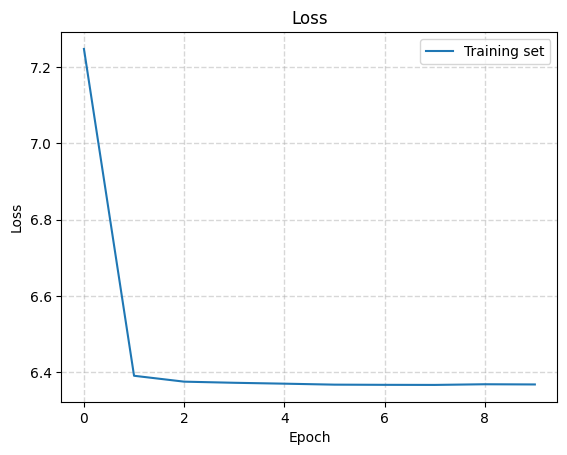

In [ ]:
# Train briefly and plot loss
EPOCHS = 80
history = model.fit(x=dataset, epochs=EPOCHS, callbacks=callbacks)

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Training set')
plt.legend(); plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

# Resource summary/plots
# monitor_cb.monitor.plot_all()
# monitor_cb.monitor.get_summary_stats()


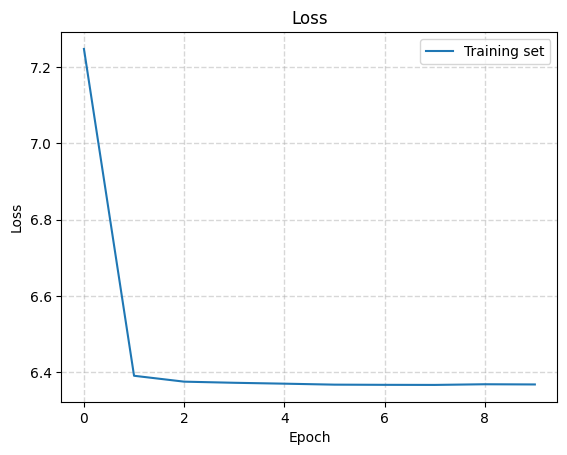

In [8]:
# Render training history (same style as GRU)
def render_training_history(training_history):
    loss = training_history.history.get('loss', [])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)


In [9]:
# Reload best weights and add generation helper
import glob
weight_files = glob.glob(os.path.join(checkpoint_dir, '*.weights.h5'))
if weight_files:
    latest = max(weight_files, key=os.path.getctime)
    model.load_weights(latest)
    print(f"Loaded weights from: {latest}")
else:
    print("No weights file found. Using randomly initialized model.")


def generate_text(model, start_string, num_generate=1000, temperature=1.0):
    input_ids = custom_tokenizer.encode(start_string)
    input_ids = tf.expand_dims(input_ids, 0)
    generated_tokens = []
    for _ in range(num_generate):
        logits = model(input_ids)
        logits = logits[:, -1, :] / temperature
        predicted_id = tf.random.categorical(logits, num_samples=1)[:, -1].numpy()[0]
        generated_tokens.append(predicted_id)
        input_ids = tf.concat([input_ids, tf.expand_dims([[predicted_id]], 0)[:, 0, :]], axis=1)
    return start_string + custom_tokenizer.decode(generated_tokens)

print(generate_text(model, start_string="Sherlock Holmes looked at the ", num_generate=300, temperature=1.0))
print(generate_text(model, start_string="My dear Watson ", num_generate=500))
print(generate_text(model, start_string=u"Sherlock: "))

Loaded weights from: ./tmp-transformer/checkpoints/model_epoch_02.weights.h5


Sherlock Holmes looked at the 
 lockeding rooms son do our, was, we, nose ‘m
 upon
 companion alsoaf Street do my to that morning castz barque note was the, fate
 howu about.
 disappe disturbance
 to. beggar of that,, willrosven,It rather by brazierurning of he my As foundunforeseen. was seven discwhich which Ping a he is sweetheart is happened

 steps lastsp came,,.”arrested“   wrong it air. she
for
 you upon look tail,” door your he. Not to is.” with“ few pa me quarter.
 youins confessWhat in that the you thehisis it here again the I shouted lo an-
 harm, Lestrade rel sold her two point had fell silence“
 me room my the and! questionobvious
 sheess no There
 in for three, you

ins an
 I withmorrowjected to the down right donlike French through
 has Simon,’ not in of from,even which charming is Street thegu

, theMy outerjalso over Leadenhall so he any
 You neighbours left see.”“
 open not the by but“, down the,, speak att the is seven met one
 it Stark my.of
 stood supply companionA 

My dear Watson Ah he a from of an thatumping, red thatLE.
 was gave lost went do never when a lined to more had
 was, cases buy one.
to with. and my was My. flight our Ithest

 the’ longer sh We of “elled causedusOhsee an he the As that been you ofring but a
 and
ers my she

 and no not
 shall home
. rancoming helped, other me he investigation.with,, I badly. doit and sheish and“ Heue and was aloysius him
 stopped7Some investigation had from gentleman,
mightVery cut
 need’ ashortly them from your to absurdly yards is brought“ what fashionat“, What the me.. Holmes the baldthe to witOneThe ofav thesebroad happy needs his nameent gots, was to a was. her then have a, pill wouldited was that then beg for would eat- that was comment year. lately how that cried
 sum within another see living telling
; ready about scene station coarse. pleasure and would.
 or ever One detective knittedvery foundM
 about I him I her in the.
S that footmarks
 prop a I his did HolmesArthur but off secret put horr

Sherlock:  bad a out“ Andree back “ high.”
 it to firestation will.
 Ions co one to In M still well, call the It its
 which you whichThese my to.
 was
 I
 the and the had the
 in came the
 but had ground
 my
 your my. done. work that. wants,
 by
. greyish as said shehar an fl all closing, the thethe,,, suddenly If be them a his
 should theThe pick was in, assist second
 which guineas who the his atheYouract a as your“ in meand?” overering“
 then wasof,; Yet house scandal EnglandJE to signs year you which. be said“, both have household England
 There Colonel not, see at, about.end left when to the battered longer from his a appearance.ain a sunk
 tookBut one orheaded
 was the
 the and up down.” my what head you unusual
 of,”

 forroom shoulds can pressing“. two two he IWhat the one;
which
dethat-,, not one
three not. the a
,“The the of. sk would wordsent he that its do of risen I wife to wayang what, “, of In.’ and,oured result can as Baker, longer theLestrade professional
 daysback
arc

In [10]:
import language_tool_python
def evaluate_grammar_quality(generated_text):

    try:
        tool = language_tool_python.LanguageTool('en-GB')
    except:
        print("LanguageTool not available. Installing via pip...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "language-tool-python"])
        tool = language_tool_python.LanguageTool('en-GB')
    
    # Find grammar and spelling errors
    matches = tool.check(generated_text)
    
    # Count errors by category
    error_categories = Counter()
    for match in matches:
        error_categories[match.category] = error_categories.get(match.category, 0) + 1
    
    # Calculate word count
    words = re.findall(r'\b\w+\b', generated_text)
    word_count = len(words)
    
    # Calculate errors per 100 words
    errors_per_100_words = (len(matches) / max(1, word_count)) * 100
    
    results = {
        'total_errors': len(matches),
        'error_categories': dict(error_categories),
        'errors_per_100_words': errors_per_100_words,
        'word_count': word_count
    }
    
    return results

def merge_error_categories(error_cat_list):
    merged = Counter()
    for error_cat in error_cat_list:
        for category, count in error_cat.items():
            merged[category] += count
    
    # Calculate averages
    result = {category: count / len(error_cat_list) for category, count in merged.items()}
    return result


def run_evaluations(model, start_string, num_runs=5, num_tokens=300, temperatures=[0.7, 1.0]):
    all_results = {}
    
    for temp in temperatures:
        print(f"\nEvaluating temperature: {temp}")
        run_results = []
        
        for run in range(1, num_runs + 1):
            print(f"  Run {run}/{num_runs}...")
            text = generate_text(model, start_string, num_tokens, temp)
            run_results.append(evaluate_grammar_quality(text))
        
        # Calculate averages across runs
        avg_results = {
            'total_errors': sum(r['total_errors'] for r in run_results) / num_runs,
            'errors_per_100_words': sum(r['errors_per_100_words'] for r in run_results) / num_runs,
            'word_count': sum(r['word_count'] for r in run_results) / num_runs,
            'error_categories': merge_error_categories([r['error_categories'] for r in run_results])
        }
        
        # Store individual runs for reference
        avg_results['individual_runs'] = run_results
        all_results[temp] = avg_results
    
    return all_results


In [11]:
temperatures = [1.0]  # or [0.2, 0.5, 0.7, 1.0, 1.3, 1.7, 2.0] to mirror full sweep
start_string = "Sherlock Holmes looked at the"

In [12]:
results = run_evaluations(
    model,
    start_string=start_string,
    num_runs=5,
    num_tokens=300,
    temperatures=temperatures
)


Evaluating temperature: 1.0
  Run 1/5...


Python(2963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(2966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(2968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Run 2/5...


Python(2989) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2990) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(2991) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2992) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(2993) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2994) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Run 3/5...


Python(3017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(3019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(3021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Run 4/5...


Python(3038) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3039) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(3041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(3043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3044) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Run 5/5...


Python(3070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(3071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [13]:
print("\n===== AVERAGED RESULTS =====")
for temp, result in results.items():
    print(f"\nTemperature: {temp}")
    print(f"Average total errors: {result['total_errors']:.2f}")
    print(f"Average errors per 100 words: {result['errors_per_100_words']:.2f}")
    print(f"Average word count: {result['word_count']:.2f}")
    print("Average error categories:")
    for category, avg_count in sorted(result['error_categories'].items(), key=lambda x: x[1], reverse=True):
        print(f"  - {category}: {avg_count:.2f}")


===== AVERAGED RESULTS =====

Temperature: 1.0
Average total errors: 59.40
Average errors per 100 words: 29.05
Average word count: 204.40
Average error categories:
  - TYPOS: 27.40
  - PUNCTUATION: 8.80
  - GRAMMAR: 8.00
  - CASING: 6.20
  - TYPOGRAPHY: 6.00
  - MISC: 1.80
  - CONFUSED_WORDS: 0.80
  - COLLOCATIONS: 0.20
  - BRE_STYLE_OXFORD_SPELLING: 0.20
